In [2]:
!pip install spacy

    100% |████████████████████████████████| 30.8MB 1.7MB/s  eta 0:00:01
    100% |████████████████████████████████| 2.1MB 29.4MB/s eta 0:00:01
    100% |████████████████████████████████| 92kB 54.9MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 22.6MB/s eta 0:00:01
    100% |████████████████████████████████| 184kB 61.9MB/s eta 0:00:01
    100% |████████████████████████████████| 51kB 40.3MB/s ta 0:00:01
You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [32]:
!python -m spacy download en_core_web_lg
!python -m spacy link en_core_web_lg web_lg --force

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Linking successful
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/en_core_web_lg
-->
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/spacy/data/web_lg
You can now load the model via spacy.load('web_lg')


In [29]:
from math import sqrt
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import spacy

In [119]:
df = pd.read_csv('https://raw.githubusercontent.com/sub-stats/ds/master/4-30-to-7-29-submissions.csv', low_memory=False)

In [120]:
nlp = spacy.load('web_lg')

In [121]:
plt.rcParams['figure.figsize'] = [10, 10]

In [139]:
col_to_parse = 'title'
df2 = pd.DataFrame()
for sub in ['askscience', 'AskHistorians', 'AskComputerScience',
       'AskCulinary', 'AskSocialScience', 'AskEngineers', 'askphilosophy']:
    condition = df['subreddit'] == sub
    df2 = df2.append(df[condition][[col_to_parse, 'subreddit']].sample(150))

In [140]:
df['subreddit'].unique()

array(['AskReddit', 'askscience', 'AskHistorians', 'AskComputerScience',
       'AskCulinary', 'TrueAskReddit', 'AskSocialScience', 'AskEngineers',
       'askphilosophy'], dtype=object)

In [141]:
tokens = []
lemma = []
pos = []
parsed_doc = [] 

for doc in nlp.pipe(df2[col_to_parse].astype('unicode').values, batch_size=50,
                        n_threads=3):
    if doc.is_parsed:
        parsed_doc.append(doc)
        tokens.append([n.text for n in doc])
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        tokens.append(None)
        lemma.append(None)
        pos.append(None)


df2['parsed_doc'] = parsed_doc
df2['comment_tokens'] = tokens
df2['comment_lemma'] = lemma
df2['pos_pos'] = pos

In [142]:
df2.head()

,title,subreddit,parsed_doc,comment_tokens,comment_lemma,pos_pos
102156,"Hi, you've probably heard of the EU meme ban. ...",askscience,"(Hi, ,, you, 've, probably, heard, of, the, EU...","[Hi, ,, you, 've, probably, heard, of, the, EU...","[hi, ,, -PRON-, have, probably, hear, of, the,...","[INTJ, PUNCT, PRON, VERB, ADV, VERB, ADP, DET,..."
43615,Question about Christians?,askscience,"(Question, about, Christians, ?)","[Question, about, Christians, ?]","[question, about, Christians, ?]","[NOUN, ADP, PROPN, PUNCT]"
79459,Is temperature something we taste or in other ...,askscience,"(Is, temperature, something, we, taste, or, in...","[Is, temperature, something, we, taste, or, in...","[be, temperature, something, -PRON-, taste, or...","[VERB, NOUN, NOUN, PRON, VERB, CCONJ, ADP, ADJ..."
58552,"How would a person realistically act, if they ...",askscience,"(How, would, a, person, realistically, act, ,,...","[How, would, a, person, realistically, act, ,,...","[how, would, a, person, realistically, act, ,,...","[ADV, VERB, DET, NOUN, ADV, VERB, PUNCT, ADP, ..."
27612,Why do indians always smell like shit?,askscience,"(Why, do, indians, always, smell, like, shit, ?)","[Why, do, indians, always, smell, like, shit, ?]","[why, do, indian, always, smell, like, shit, ?]","[ADV, VERB, NOUN, ADV, VERB, ADP, NOUN, PUNCT]"


In [143]:
df2.shape

(1050, 6)

In [144]:
df2['subreddit'].value_counts()

AskCulinary           150
AskComputerScience    150
askphilosophy         150
AskEngineers          150
askscience            150
AskHistorians         150
AskSocialScience      150
Name: subreddit, dtype: int64

In [145]:
df3 = df2.copy()
df3 = df3.reset_index()

In [146]:
df3['parsed_doc'][0].similarity(df3['parsed_doc'][1])

0.7302806403031326

In [147]:
# Empty graph                            
raw_G = nx.Graph()
n = 0

# Iterate over every combination of two titles
for i_pos, i in enumerate(df3['parsed_doc']):
    for j in range(i_pos+1, len(df3['parsed_doc'])):
        # If mirrored edge not present, add edge
        if not (raw_G.has_edge(df3['parsed_doc'][j], i)):
            sim = i.similarity(df3['parsed_doc'][j])
            raw_G.add_edge(i, df3['parsed_doc'][j], weight = sim)
            n += 1

print(raw_G.number_of_nodes(), "nodes, and", raw_G.number_of_edges(), "edges created.")

1050 nodes, and 550725 edges created.


In [148]:
edges_to_kill = []
min_wt = 0.93      # this is our cutoff value for a minimum edge-weight 

for n, nbrs in raw_G.adj.items():
    for nbr, eattr in nbrs.items():
        # remove edges below a certain weight
        data = eattr['weight']
        if data < min_wt:
            edges_to_kill.append((n, nbr)) 
            
print("\n", len(edges_to_kill) / 2, "edges to kill (of", raw_G.number_of_edges(), "), before de-duplicating")


 549960.0 edges to kill (of 550725 ), before de-duplicating


In [149]:
for u, v in edges_to_kill:
    if raw_G.has_edge(u, v):   # catches (e.g.) those edges where we've removed them using reverse ... (v, u)
        raw_G.remove_edge(u, v)

In [150]:
strong_G = raw_G
print(strong_G.number_of_edges())

765


In [151]:
title = df2['title'].to_list()
sub = df2['subreddit'].to_list()
sub_map = dict(zip(title, sub))

color_map = {'AskReddit':'black', 
             'askscience':'red', 
             'AskHistorians':'green', 
             'AskComputerScience':'blue',
             'AskCulinary':'yellow', 
             'TrueAskReddit':'orange', 
             'AskSocialScience':'purple', 
             'AskEngineers':'pink',
             'askphilosophy':'silver'}

color_list = []
for node in strong_G:
    color_list.append(color_map[sub_map[str(node)]])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


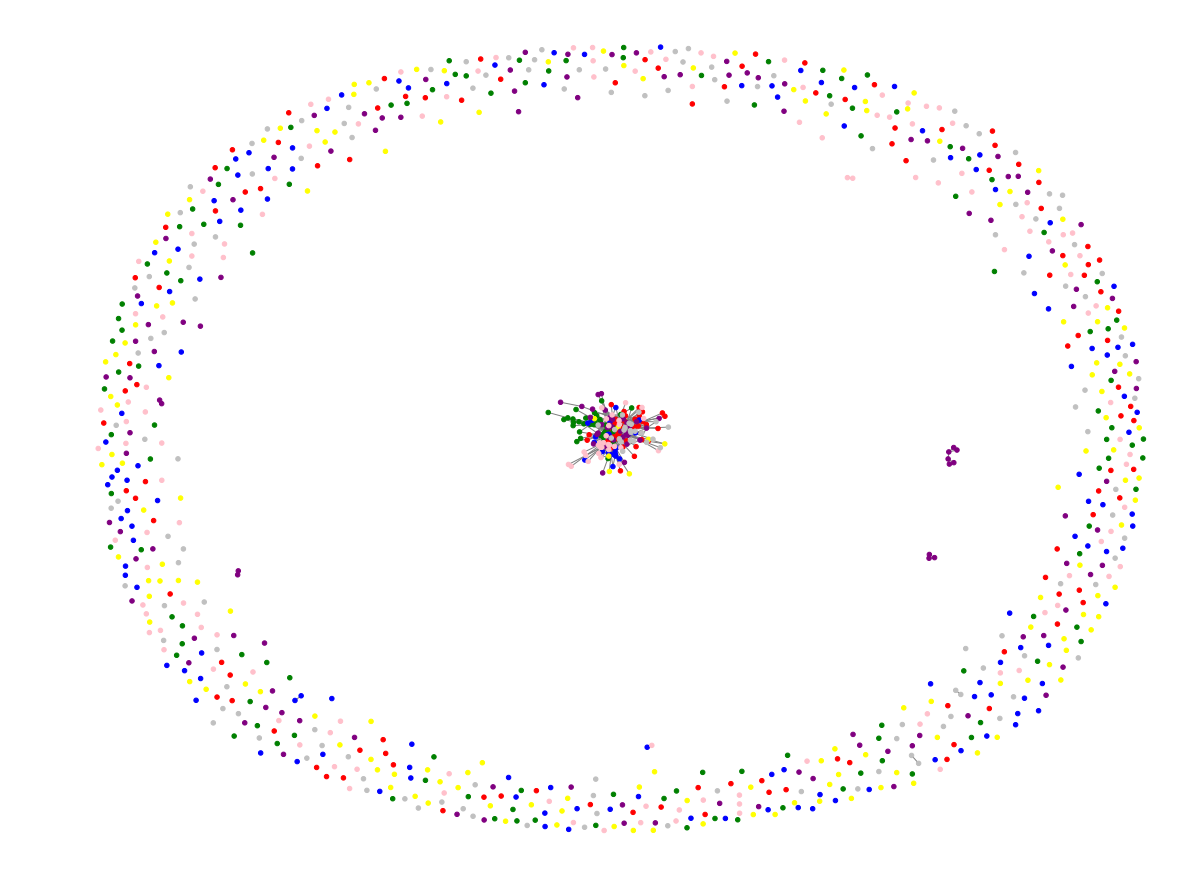

In [152]:
nx.draw(strong_G, node_size=20, edge_color='gray', node_color=color_list)

In [153]:
strong_G.remove_nodes_from(list(nx.isolates(strong_G)))

In [156]:
title = df2['title'].to_list()
sub = df2['subreddit'].to_list()
sub_map = dict(zip(title, sub))

color_map = {'AskReddit':'silver', 
             'askscience':'red', 
             'AskHistorians':'green', 
             'AskComputerScience':'blue',
             'AskCulinary':'yellow', 
             'TrueAskReddit':'orange', 
             'AskSocialScience':'purple', 
             'AskEngineers':'pink',
             'askphilosophy':'black'}

color_list = []
for node in strong_G:
    color_list.append(color_map[sub_map[str(node)]])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


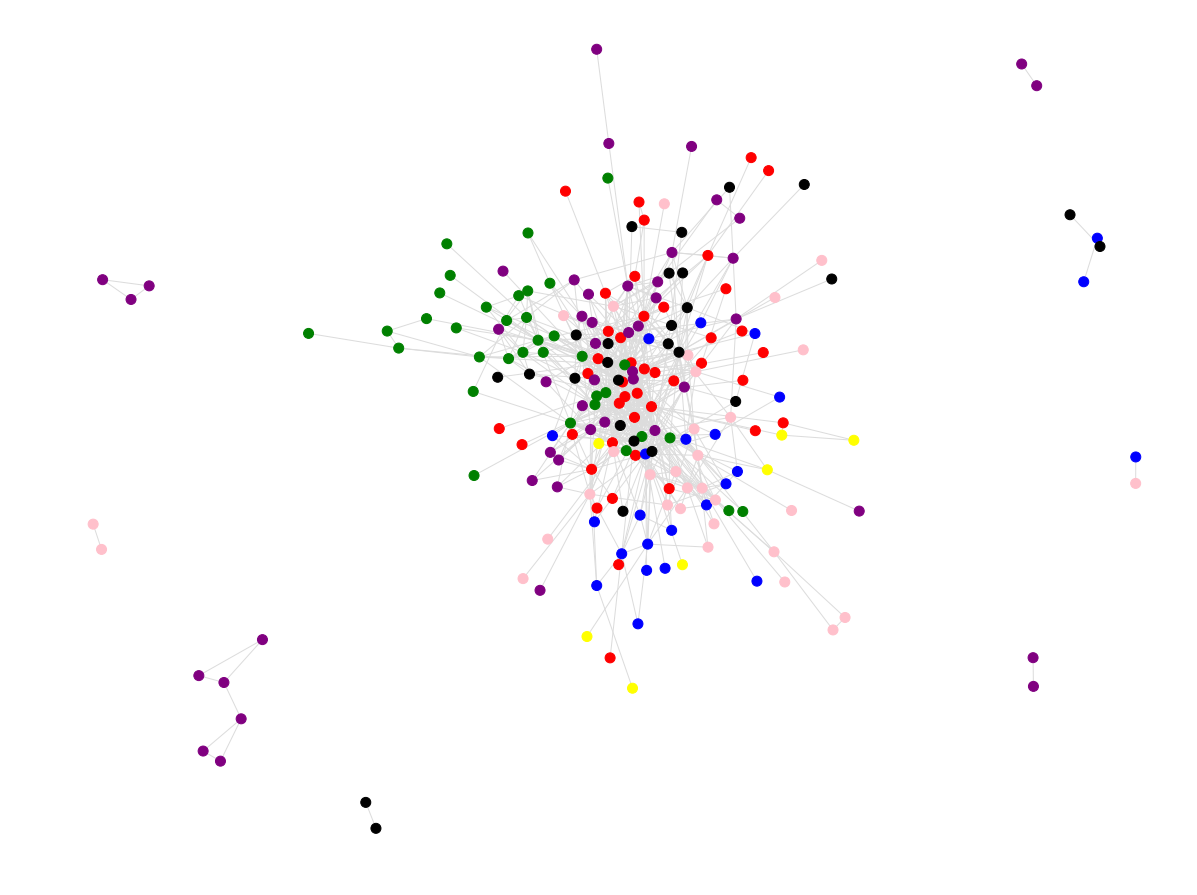

In [157]:
count = strong_G.number_of_nodes()
equilibrium = 10 / sqrt(count)    # default for this is 1/sqrt(n), but this will 'blow out' the layout for better visibility
plt.rcParams['figure.figsize'] = [16, 12]  # a better aspect ratio for labelled nodes
pos = nx.fruchterman_reingold_layout(strong_G, k=equilibrium, iterations=300)
nx.draw(strong_G, pos, node_size=100, edge_color='gainsboro', with_labels=False, node_color=color_list)

plt.show()